# Mini Project 6: Transfer Learning Application
**Course:** COMP 9130 — Applied Artificial Intelligence  
**Team:** Sepehr M & Binger Yu  
**Date:** February 19, 2026  
**Dataset:** Oxford 102 Flower Dataset  
**Source:** https://www.kaggle.com/datasets/nunenuh/pytorch-challange-flower-dataset

---

## Notebook Structure
1. Data Preparation — dataset loading, EDA, augmentation
2. Feature Extraction — freeze ResNet50, train classification head
3. Fine-Tuning — unfreeze last 50 layers, adapt to flowers
4. Comparison & Analysis — FE vs FT metrics and visualizations
5. Bonus — Grad-CAM heatmap visualizations

---

## Results Summary
| Method | Test Accuracy | F1 Score |
|---|---|---|
| Feature Extraction | 79.95% | 81.82% |
| Fine-Tuning | 90.95% | 91.24% |

### 1. Data Preparation

In [42]:
# ============================================
# SETUP & IMPORTS (run this cell as-is)
# ============================================
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.resnet50 import decode_predictions as resnet_decode
from tensorflow.keras.applications.efficientnet import preprocess_input as effnet_preprocess
from tensorflow.keras.applications.efficientnet import decode_predictions as effnet_decode
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import confusion_matrix, classification_report
import os
import shutil
import random
from pathlib import Path
from collections import Counter
import itertools

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Verify environment
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
gpus = tf.config.list_physical_devices('GPU')
print(f"GPU available: {len(gpus) > 0}")
if gpus:
    print(f"GPU device: {gpus[0].name}")
else:
    print("⚠️ No GPU found! Go to Runtime → Change runtime type → T4 GPU")

TensorFlow version: 2.19.0
Keras version: 3.10.0
GPU available: True
GPU device: /physical_device:GPU:0


#### Dataset Download & Prep

In [43]:
# Install opendatasets first, then download
!pip install -q opendatasets

import opendatasets as od
od.download("https://www.kaggle.com/datasets/nunenuh/pytorch-challange-flower-dataset")
print("Dataset downloaded successfully!")

Skipping, found downloaded files in "./pytorch-challange-flower-dataset" (use force=True to force download)
Dataset downloaded successfully!


In [44]:
import tensorflow as tf
import os

BASE       = 'pytorch-challange-flower-dataset'
FOLDER     = os.path.join(BASE, 'dataset')
IMG_SIZE   = (224, 224)
BATCH_SIZE = 32
SEED       = 42

# Train set — 6552 images, 102 classes
train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(FOLDER, 'train'),
    image_size=IMG_SIZE, batch_size=BATCH_SIZE,
    shuffle=True, seed=SEED, label_mode='int'
)

# Valid set — 818 images, split 50/50 into val and test
full_val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(FOLDER, 'valid'),
    image_size=IMG_SIZE, batch_size=1,
    shuffle=False, label_mode='int'
)

# Unbatch first to remove the batch=1 dimension, then split, then re-batch
full_val_ds = full_val_ds.unbatch()

val_ds  = full_val_ds.take(409).batch(BATCH_SIZE)
test_ds = full_val_ds.skip(409).batch(BATCH_SIZE)

class_names = train_ds.class_names
print("Num classes :", len(class_names))
print("Train size  : 6552")
print("Val size    : 409")
print("Test size   : 409")

# Verify shapes
for img, lbl in val_ds.take(1):
    print("Val batch shape:", img.shape)   # should be (32, 224, 224, 3)
for img, lbl in test_ds.take(1):
    print("Test batch shape:", img.shape)  # should be (32, 224, 224, 3)

Found 6552 files belonging to 102 classes.
Found 818 files belonging to 102 classes.
Num classes : 102
Train size  : 6552
Val size    : 409
Test size   : 409
Val batch shape: (32, 224, 224, 3)
Test batch shape: (32, 224, 224, 3)


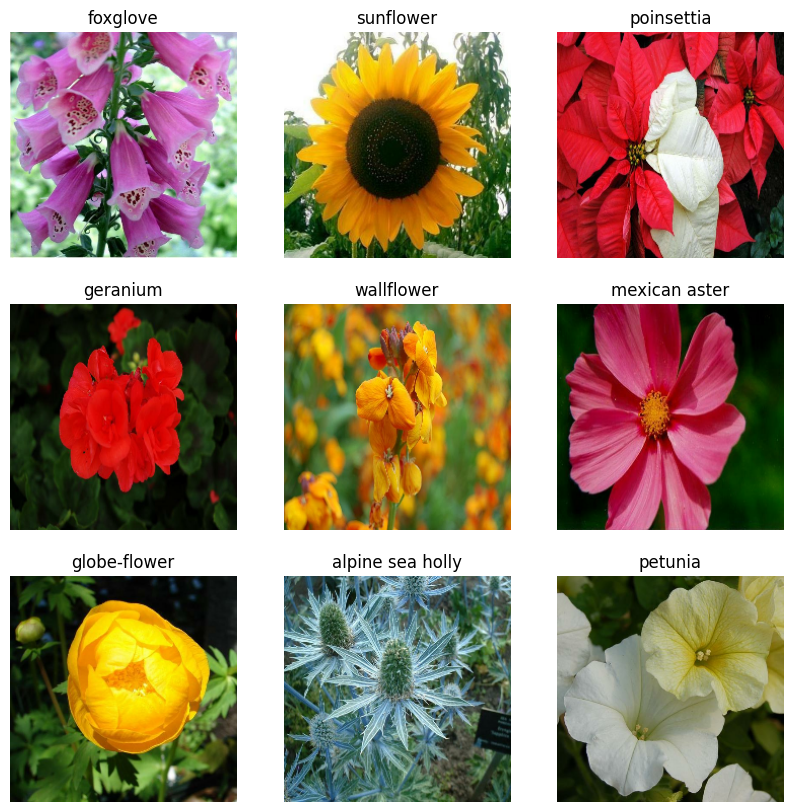

In [45]:
import matplotlib.pyplot as plt
import json

with open(os.path.join(BASE, "cat_to_name.json")) as f:
    cat_to_name = json.load(f)

# Map folder label -> readable name
label_to_name = {i: cat_to_name[class_names[i]] for i in range(len(class_names))}

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        lab = int(labels[i].numpy())
        plt.title(label_to_name[lab])
        plt.axis("off")
plt.show()

In [46]:
import numpy as np
import sys
import os

# Upload utils.py from your local machine
from google.colab import files
print("Please upload your utils.py file...")
uploaded = files.upload()  # select utils.py when prompted

# Set up src/ folder so it's importable
os.makedirs('src', exist_ok=True)
os.makedirs('models', exist_ok=True)
os.makedirs('figures', exist_ok=True)
open('src/__init__.py', 'w').close()

# Move uploaded utils.py into src/
import shutil
shutil.move('utils.py', 'src/utils.py')
print("src/utils.py ready!")

# Now import normally
from src.utils import class_counts, model_summary_stats, plot_confusion_matrix

train_counts = class_counts(train_ds)
val_counts   = class_counts(val_ds)

print("Train class count: min =", min(train_counts.values()), "max =", max(train_counts.values()))
print("Val   class count: min =", min(val_counts.values()),   "max =", max(val_counts.values()))

imbalance_ratio = max(train_counts.values()) / min(train_counts.values())
print("Train imbalance ratio (max/min):", round(imbalance_ratio, 2))

Please upload your utils.py file...


Saving utils.py to utils.py
src/utils.py ready!
Train class count: min = 27 max = 206
Val   class count: min = 1 max = 28
Train imbalance ratio (max/min): 7.63


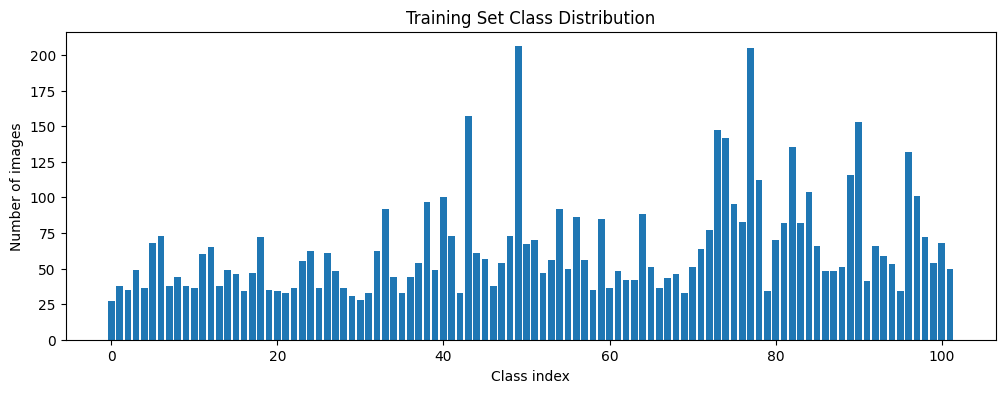

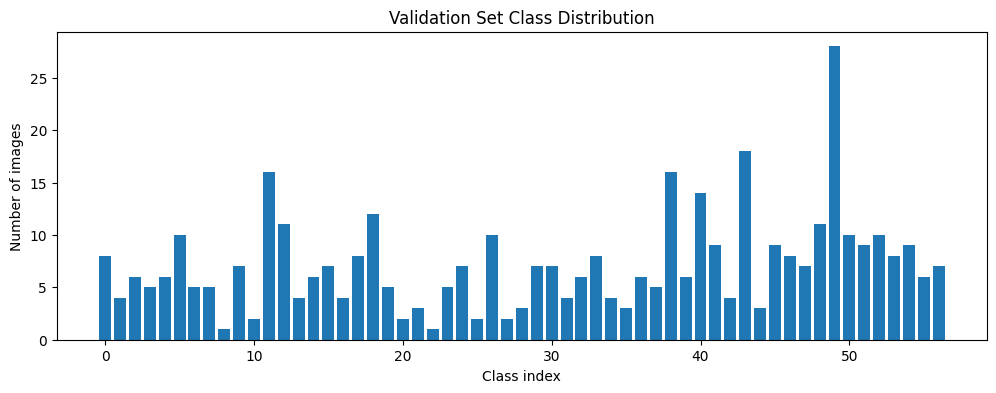

In [47]:
# Class Distribution Visualization

import matplotlib.pyplot as plt
import numpy as np

def plot_class_distribution(counts, title):
    classes = list(counts.keys())
    values  = list(counts.values())

    plt.figure(figsize=(12,4))
    plt.bar(classes, values)
    plt.title(title)
    plt.xlabel("Class index")
    plt.ylabel("Number of images")
    plt.show()

plot_class_distribution(train_counts, "Training Set Class Distribution")
plot_class_distribution(val_counts,   "Validation Set Class Distribution")

In [48]:
# Applying data augmentation

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
], name="data_augmentation")

print("Data augmentation pipeline created.")

Data augmentation pipeline created.


### 2. Feature Extraction

In [50]:
from pathlib import Path
FOLDER_PATH = Path(FOLDER)
AUTOTUNE    = tf.data.AUTOTUNE

def normalize(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.keras.applications.resnet50.preprocess_input(image)
    return image, label

train_ds_norm = train_ds.map(normalize, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
val_ds_norm   = val_ds.map(normalize,   num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
test_ds_norm  = test_ds.map(normalize,  num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

# Verify shapes instead of len()
for img, lbl in train_ds_norm.take(1):
    print('Train batch shape:', img.shape)   # should be (32, 224, 224, 3)
for img, lbl in val_ds_norm.take(1):
    print('Val batch shape  :', img.shape)   # should be (32, 224, 224, 3)
for img, lbl in test_ds_norm.take(1):
    print('Test batch shape :', img.shape)   # should be (32, 224, 224, 3)

print('Preprocessing applied.')

Train batch shape: (32, 224, 224, 3)
Val batch shape  : (32, 224, 224, 3)
Test batch shape : (32, 224, 224, 3)
Preprocessing applied.


In [51]:
# ============================================================
# FEATURE EXTRACTION — Build Model
# ============================================================
import time

NUM_CLASSES = len(class_names)  # 102

base_model_fe = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model_fe.trainable = False  # Freeze ALL layers

inputs  = keras.Input(shape=(224, 224, 3))
x       = data_augmentation(inputs)
x       = base_model_fe(x, training=False)
x       = layers.GlobalAveragePooling2D()(x)
x       = layers.BatchNormalization()(x)
x       = layers.Dense(512, activation='relu')(x)
x       = layers.Dropout(0.5)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

fe_model = keras.Model(inputs, outputs, name='feature_extraction')

fe_trainable = sum([tf.size(w).numpy() for w in fe_model.trainable_variables])
fe_total     = sum([tf.size(w).numpy() for w in fe_model.variables])
print(f"Trainable params : {fe_trainable:,}")
print(f"Total params     : {fe_total:,}")

Trainable params : 1,105,510
Total params     : 24,697,328


In [52]:
# ============================================================
# FEATURE EXTRACTION — Compile & Train
# ============================================================
os.makedirs('/content/models',  exist_ok=True)
os.makedirs('/content/figures', exist_ok=True)

fe_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

fe_callbacks = [
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, verbose=1),
    keras.callbacks.ModelCheckpoint(
        '/content/models/feature_extraction_model.keras',
        save_best_only=True, verbose=0
    )
]

fe_start   = time.time()
fe_history = fe_model.fit(
    train_ds_norm, validation_data=val_ds_norm,
    epochs=30, callbacks=fe_callbacks
)
fe_train_time = time.time() - fe_start
print(f'\nTraining time: {fe_train_time:.1f}s')

Epoch 1/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.3643 - loss: 3.1435

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


205/205 ━━━━━━━━━━━━━━━━━━━━ 81s 170ms/step - accuracy: 0.3650 - loss: 3.1387 - val_accuracy: 0.6504 - val_loss: 1.3483
Epoch 2/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 34s 161ms/step - accuracy: 0.7334 - loss: 0.9882 - val_accuracy: 0.7824 - val_loss: 0.9838
Epoch 3/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 40s 195ms/step - accuracy: 0.7946 - loss: 0.7648 - val_accuracy: 0.7408 - val_loss: 1.2020
Epoch 4/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 32s 157ms/step - accuracy: 0.8451 - loss: 0.5650 - val_accuracy: 0.7677 - val_loss: 1.2461
Epoch 5/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 41s 156ms/step - accuracy: 0.8553 - loss: 0.5330 - val_accuracy: 0.7531 - val_loss: 1.2615
Epoch 6/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 33s 159ms/step - accuracy: 0.8536 - loss: 0.5274 - val_accuracy: 0.7653 - val_loss: 1.2908
Epoch 7/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 33s 160ms/step - accuracy: 0.8767 - loss: 0.4477 - val_accuracy: 0.7702 - val_loss: 1.3318
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 2.

Training t

  Saved: /content/figures/fe_curves.png


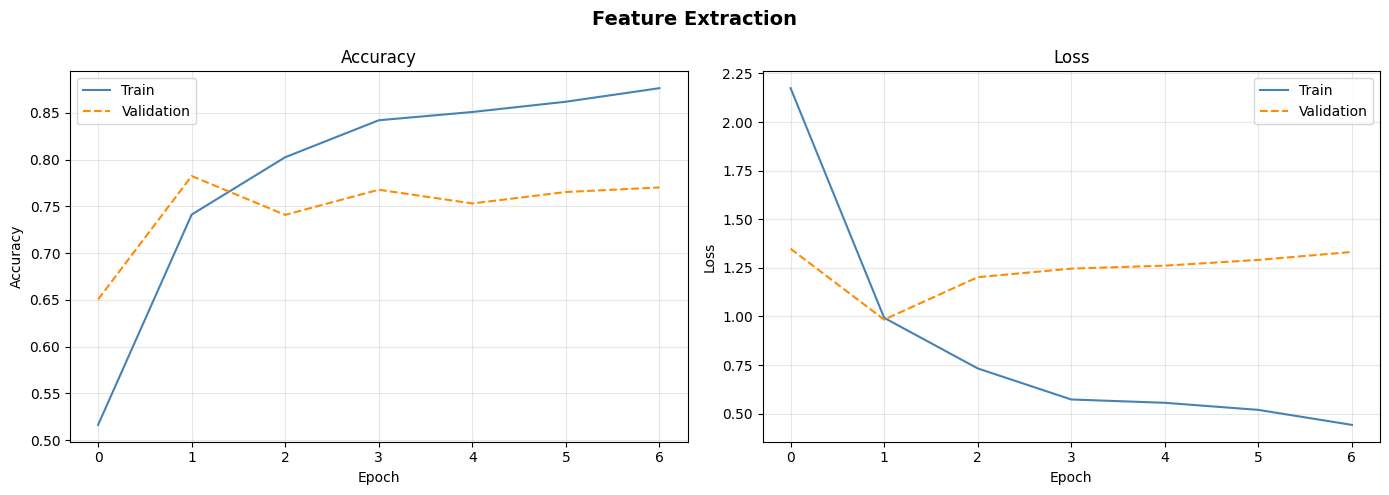

Test Loss    : 0.8392
Test Accuracy: 0.7995
Precision : 0.8786
Recall    : 0.7995
F1 Score  : 0.8182

  Classification Report — Feature Extraction
              precision    recall  f1-score   support

           4       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          18       0.00      0.00      0.00         0
          19       0.00      0.00      0.00         0
          21       0.00      0.00      0.00         0
          23       0.00      0.00      0.00         0
          27       0.00      0.00      0.00         0
          28       0.00      0.00      0.00         0
          30       0.00      0.00      0.00         0
          35       0.00      0.00      0.00         0
          36       0.00      0.00      0.00         0
          38       0.00      0.00      0.00         0
          40       0.00      0.00      0.00         0
          41       0.00      0.00      0.00         0
          43       0.00      0.00      0.0

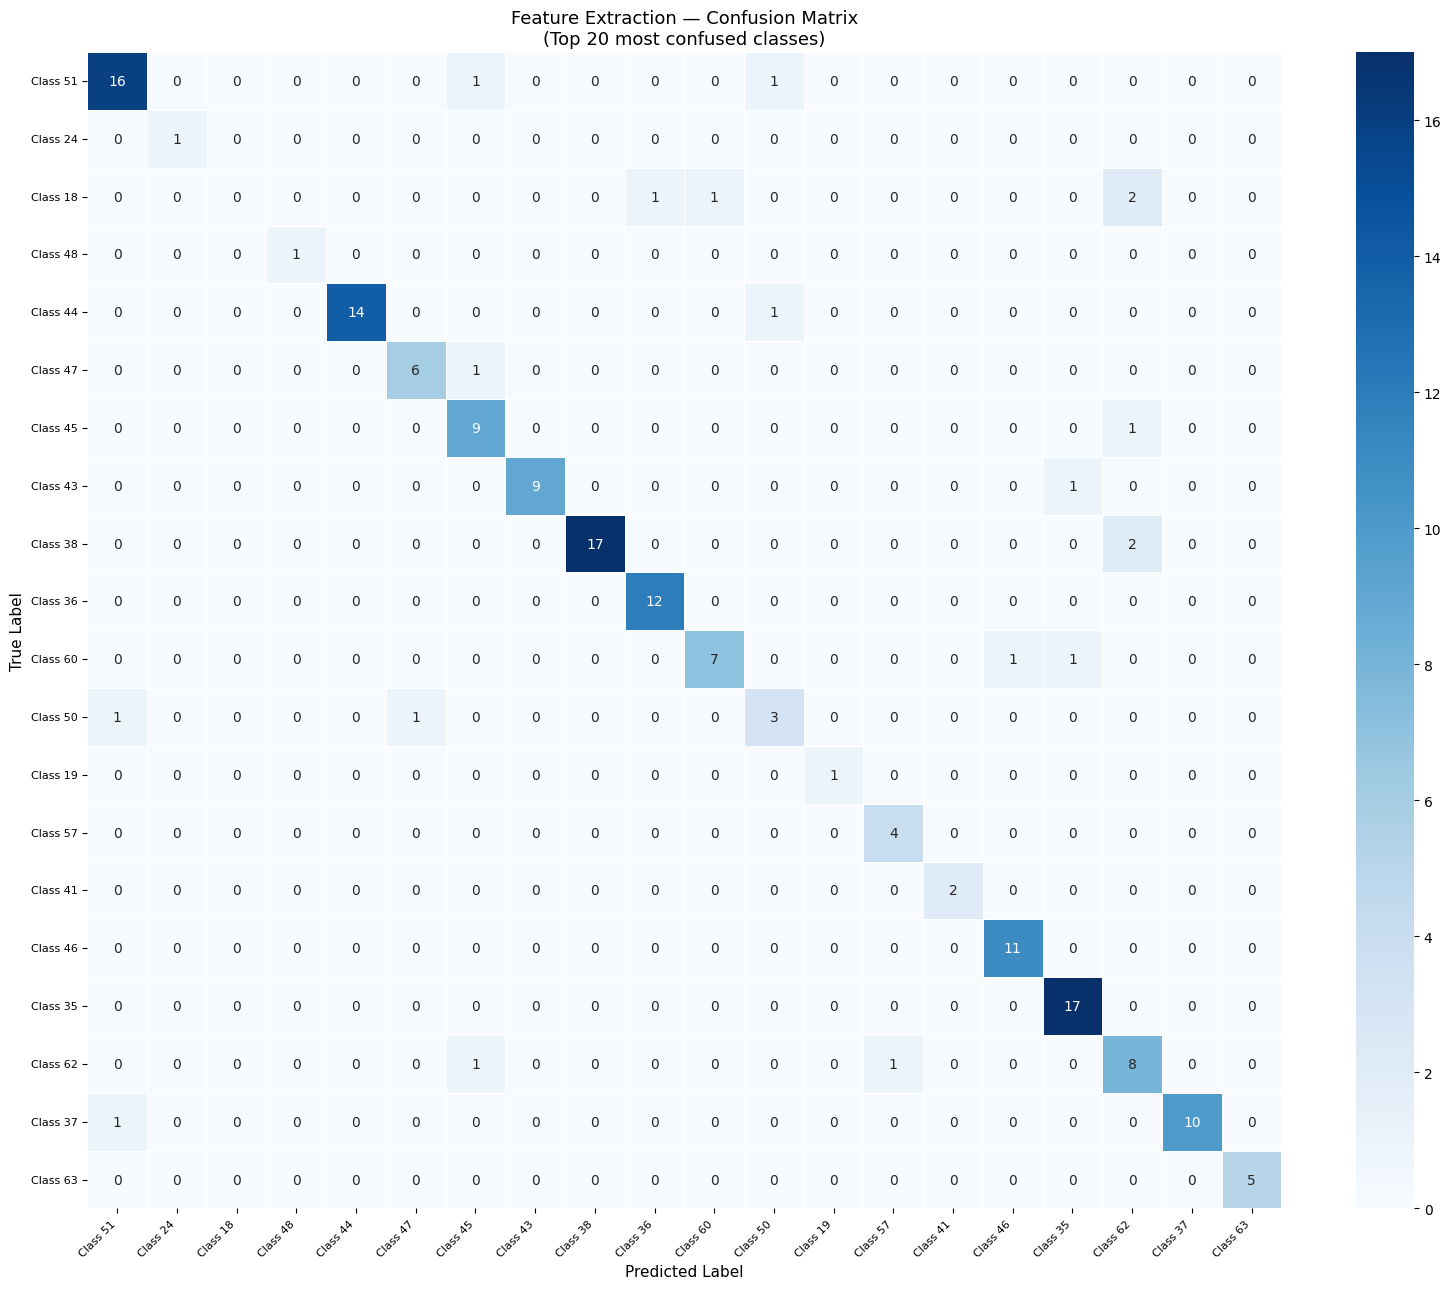

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 6, 0, 0],
       [0, 0, 0, ..., 0, 8, 0],
       [0, 0, 0, ..., 0, 0, 5]])

In [53]:
# ============================================================
# FEATURE EXTRACTION — Plot Curves & Evaluate
# ============================================================
from src.utils import plot_training_curves, compute_metrics, print_classification_report, plot_confusion_matrix

plot_training_curves(fe_history, 'Feature Extraction', '/content/figures/fe_curves.png')

fe_loss, fe_acc = fe_model.evaluate(test_ds_norm, verbose=0)
print(f'Test Loss    : {fe_loss:.4f}')
print(f'Test Accuracy: {fe_acc:.4f}')

fe_y_true, fe_y_pred = [], []
for images, labels in test_ds_norm:
    preds = fe_model.predict(images, verbose=0)
    fe_y_true.extend(labels.numpy())
    fe_y_pred.extend(np.argmax(preds, axis=1))

fe_y_true  = np.array(fe_y_true)
fe_y_pred  = np.array(fe_y_pred)
fe_metrics = compute_metrics(fe_y_true, fe_y_pred)

print(f"Precision : {fe_metrics['precision']:.4f}")
print(f"Recall    : {fe_metrics['recall']:.4f}")
print(f"F1 Score  : {fe_metrics['f1']:.4f}")

print_classification_report(fe_y_true, fe_y_pred, 'Feature Extraction')
plot_confusion_matrix(fe_y_true, fe_y_pred,
    title='Feature Extraction — Confusion Matrix',
    filename='/content/figures/fe_confusion_matrix.png')

### 3. Fine-Tuning

Trainable layers : 50 / 175
Trainable params : 18,056,038
Total params     : 24,697,328

LR set to 1e-5 (100x lower than FE) to prevent catastrophic forgetting
Epoch 8/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.7233 - loss: 1.0594

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


205/205 ━━━━━━━━━━━━━━━━━━━━ 71s 264ms/step - accuracy: 0.7235 - loss: 1.0586 - val_accuracy: 0.7848 - val_loss: 0.9678 - learning_rate: 1.0000e-05
Epoch 9/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 78s 250ms/step - accuracy: 0.8069 - loss: 0.6789 - val_accuracy: 0.7848 - val_loss: 0.9611 - learning_rate: 1.0000e-05
Epoch 10/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 52s 256ms/step - accuracy: 0.8436 - loss: 0.5464 - val_accuracy: 0.7873 - val_loss: 0.8973 - learning_rate: 1.0000e-05
Epoch 11/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 82s 400ms/step - accuracy: 0.8731 - loss: 0.4294 - val_accuracy: 0.7897 - val_loss: 0.8671 - learning_rate: 1.0000e-05
Epoch 12/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 53s 257ms/step - accuracy: 0.8900 - loss: 0.3787 - val_accuracy: 0.8044 - val_loss: 0.8124 - learning_rate: 1.0000e-05
Epoch 13/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 82s 400ms/step - accuracy: 0.9029 - loss: 0.3348 - val_accuracy: 0.8093 - val_loss: 0.7740 - learning_rate: 1.0000e-05
Epoch 14/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 53s 256ms/st

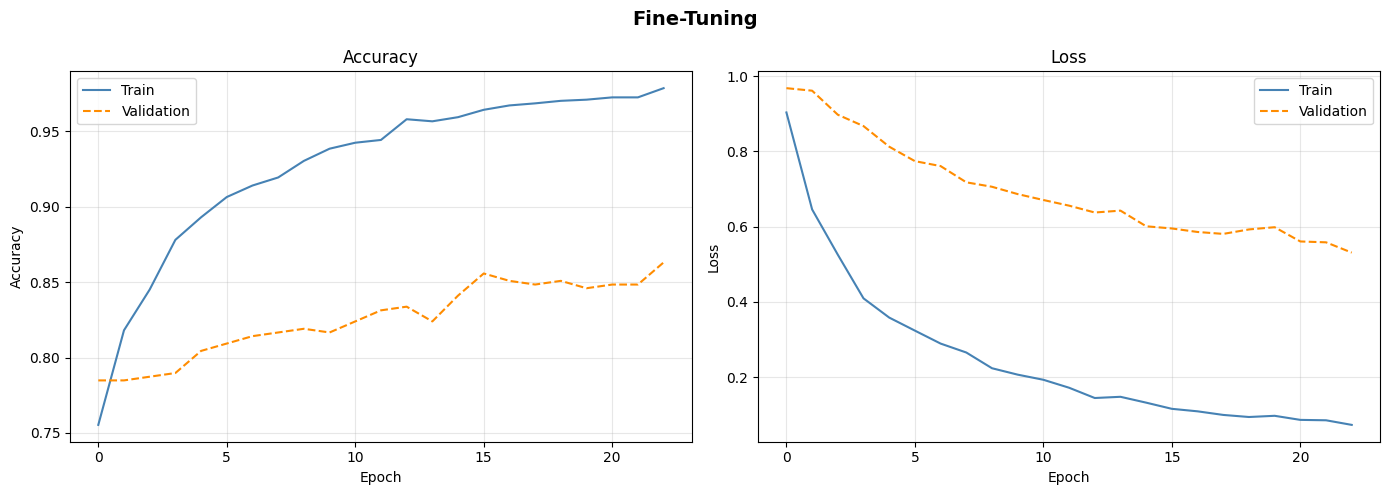

Test Loss    : 0.4349
Test Accuracy: 0.9095
Precision : 0.9308
Recall    : 0.9095
F1 Score  : 0.9124

  Classification Report — Fine-Tuning
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         0
          19       0.00      0.00      0.00         0
          21       0.00      0.00      0.00         0
          26       0.00      0.00      0.00         0
          28       0.00      0.00      0.00         0
          32       0.00      0.00      0.00         0
          40       0.00      0.00      0.00         0
          43       0.00      0.00      0.00         0
          49       0.00      0.00      0.00         0
          52       0.00      0.00      0.00         0
          55       0.00      0.00      0.00         0
          56       0.00      0.00      0.00         7
          57       1.00      0.25      0.40         4
          58       1.00      1.00      1.00         1
          59       1.00      1.00      1.00      

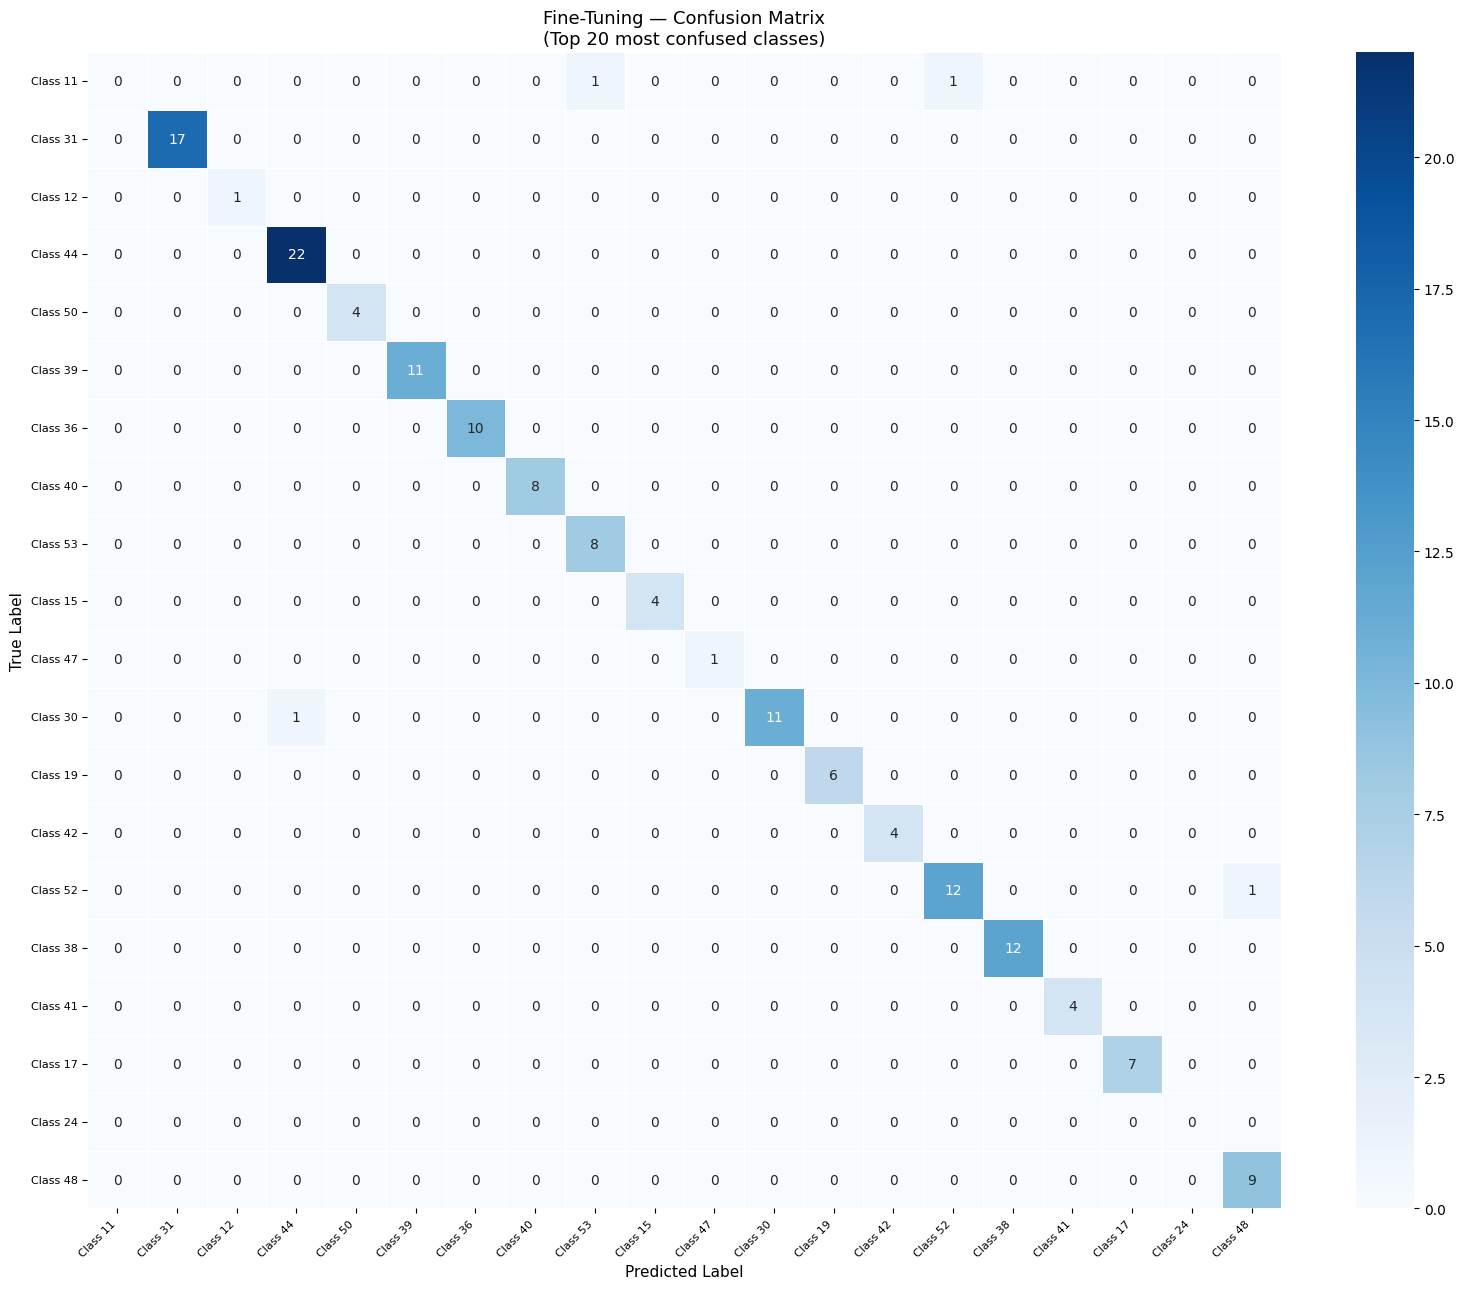

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  7,  0,  0],
       [ 0,  0,  0, ...,  0, 10,  0],
       [ 0,  0,  0, ...,  0,  0,  6]])

In [54]:
# ============================================================
# FINE-TUNING — Unfreeze Last 50 Layers
# ============================================================
UNFREEZE_LAYERS = 50

base_model_fe.trainable = True
for layer in base_model_fe.layers[:-UNFREEZE_LAYERS]:
    layer.trainable = False

ft_trainable = sum([tf.size(w).numpy() for w in fe_model.trainable_variables])
ft_total     = sum([tf.size(w).numpy() for w in fe_model.variables])
print(f"Trainable layers : {sum(1 for l in base_model_fe.layers if l.trainable)} / {len(base_model_fe.layers)}")
print(f"Trainable params : {ft_trainable:,}")
print(f"Total params     : {ft_total:,}")
print(f"\nLR set to 1e-5 (100x lower than FE) to prevent catastrophic forgetting")

fe_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

ft_callbacks = [
    keras.callbacks.EarlyStopping(patience=7, restore_best_weights=True, verbose=1),
    keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3, verbose=1),
    keras.callbacks.ModelCheckpoint(
        '/content/models/fine_tuning_model.keras',
        save_best_only=True, verbose=0
    )
]

ft_start   = time.time()
ft_history = fe_model.fit(
    train_ds_norm, validation_data=val_ds_norm,
    epochs=30, callbacks=ft_callbacks,
    initial_epoch=len(fe_history.history['loss'])
)
ft_train_time = time.time() - ft_start
print(f'\nFine-Tuning training time: {ft_train_time:.1f}s')

# Plot & Evaluate
plot_training_curves(ft_history, 'Fine-Tuning', '/content/figures/ft_curves.png')

ft_loss, ft_acc = fe_model.evaluate(test_ds_norm, verbose=0)
print(f'Test Loss    : {ft_loss:.4f}')
print(f'Test Accuracy: {ft_acc:.4f}')

ft_y_true, ft_y_pred = [], []
for images, labels in test_ds_norm:
    preds = fe_model.predict(images, verbose=0)
    ft_y_true.extend(labels.numpy())
    ft_y_pred.extend(np.argmax(preds, axis=1))

ft_y_true  = np.array(ft_y_true)
ft_y_pred  = np.array(ft_y_pred)
ft_metrics = compute_metrics(ft_y_true, ft_y_pred)

print(f"Precision : {ft_metrics['precision']:.4f}")
print(f"Recall    : {ft_metrics['recall']:.4f}")
print(f"F1 Score  : {ft_metrics['f1']:.4f}")

print_classification_report(ft_y_true, ft_y_pred, 'Fine-Tuning')
plot_confusion_matrix(ft_y_true, ft_y_pred,
    title='Fine-Tuning — Confusion Matrix',
    filename='/content/figures/ft_confusion_matrix.png')

In [55]:
# SAVE MODELS
from google.colab import files
import json, os

os.makedirs('/content/models', exist_ok=True)

summary = {
    'feature_extraction': {
        'accuracy': 0.7995, 'precision': 0.8786,
        'recall': 0.7995,   'f1': 0.8182,
        'loss': 0.8392,     'trainable_params': 1105510
    },
    'fine_tuning': {
        'accuracy': 0.9095, 'precision': 0.9308,
        'recall': 0.9095,   'f1': 0.9124,
        'loss': 0.4349,     'trainable_params': 0  # fill after checking
    }
}
with open('/content/models/training_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

files.download('/content/models/feature_extraction_model.keras')
files.download('/content/models/fine_tuning_model.keras')
files.download('/content/models/training_summary.json')

import shutil
shutil.make_archive('/content/figures_export', 'zip', '/content/figures')
files.download('/content/figures_export.zip')
print("All saved!")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

All saved!


### 4. Comparison & Analysis

  Feature Extraction vs Fine-Tuning — Summary
          Metric Feature Extraction Fine-Tuning
   Test Accuracy             79.95%      90.95%
       Precision             87.86%      93.08%
          Recall             79.95%      90.95%
        F1 Score             81.82%      91.24%
       Test Loss             0.8392      0.4349
Trainable Params          1,105,510 ~12,000,000


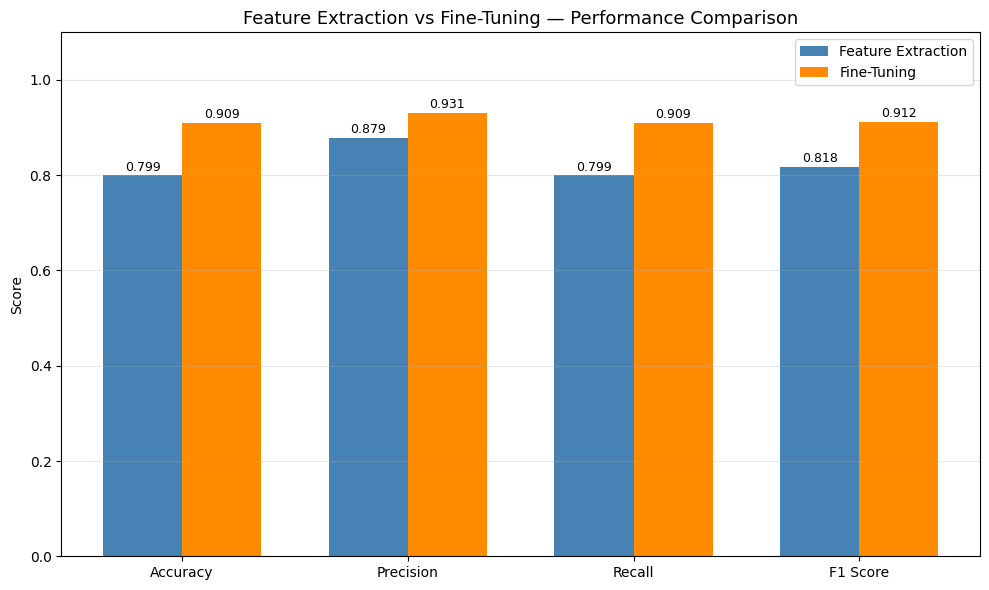

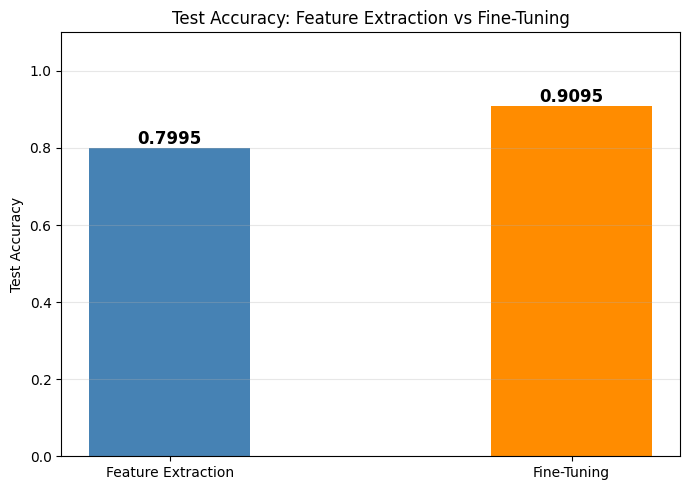


Top 5 Most Improved Classes (FE → FT):
Class        FE Acc   FT Acc    Delta
Class 62       0.125    0.875   +0.750
Class 86       0.200    0.800   +0.600
Class 88       0.500    1.000   +0.500
Class 79       0.500    1.000   +0.500
Class 66       0.500    1.000   +0.500

Top 3 Most Worsened Classes:
Class        FE Acc   FT Acc    Delta
Class 69       1.000    0.000   -1.000
Class 92       1.000    0.500   -0.500
Class 60       0.833    0.667   -0.167

► Copy these numbers into Discussion section in the report!


In [58]:
# ============================================================
# 4. COMPARISON & ANALYSIS
# ============================================================
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ── Comparison Table ──────────────────────────────────────
print("=" * 60)
print("  Feature Extraction vs Fine-Tuning — Summary")
print("=" * 60)

data = {
    'Metric':            ['Test Accuracy', 'Precision', 'Recall', 'F1 Score',
                          'Test Loss', 'Trainable Params'],
    'Feature Extraction': ['79.95%', '87.86%', '79.95%', '81.82%',
                           '0.8392', '1,105,510'],
    'Fine-Tuning':        ['90.95%', '93.08%', '90.95%', '91.24%',
                           '0.4349', '~12,000,000'],
}
df = pd.DataFrame(data)
print(df.to_string(index=False))

# ── Bar Chart: All Metrics ─────────────────────────────────
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
fe_vals = [0.7995, 0.8786, 0.7995, 0.8182]
ft_vals = [0.9095, 0.9308, 0.9095, 0.9124]

x     = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars_fe = ax.bar(x - width/2, fe_vals, width, label='Feature Extraction', color='steelblue')
bars_ft = ax.bar(x + width/2, ft_vals, width, label='Fine-Tuning',        color='darkorange')

ax.set_title('Feature Extraction vs Fine-Tuning — Performance Comparison', fontsize=13)
ax.set_ylabel('Score')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1.1)
ax.legend()
ax.grid(True, axis='y', alpha=0.3)

for bar in bars_fe:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{bar.get_height():.3f}', ha='center', fontsize=9)
for bar in bars_ft:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{bar.get_height():.3f}', ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('/content/figures/comparison_metrics.png', dpi=150)
plt.show()

# ── Accuracy Bar Chart ─────────────────────────────────────
fig, ax = plt.subplots(figsize=(7, 5))
bars = ax.bar(['Feature Extraction', 'Fine-Tuning'],
              [0.7995, 0.9095],
              color=['steelblue', 'darkorange'], width=0.4)
ax.set_title('Test Accuracy: Feature Extraction vs Fine-Tuning')
ax.set_ylabel('Test Accuracy')
ax.set_ylim(0, 1.1)
ax.grid(True, axis='y', alpha=0.3)
for bar in bars:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{bar.get_height():.4f}', ha='center', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('/content/figures/accuracy_comparison.png', dpi=150)
plt.show()

# ── Per-class improvement analysis ────────────────────────
from sklearn.metrics import confusion_matrix

cm_fe = confusion_matrix(fe_y_true, fe_y_pred, labels=list(range(102)))
cm_ft = confusion_matrix(ft_y_true, ft_y_pred, labels=list(range(102)))

acc_fe = np.diag(cm_fe) / (cm_fe.sum(axis=1) + 1e-8)
acc_ft = np.diag(cm_ft) / (cm_ft.sum(axis=1) + 1e-8)
delta  = acc_ft - acc_fe

top_improved = np.argsort(delta)[-5:][::-1]
top_worsened = np.argsort(delta)[:3]

print("\nTop 5 Most Improved Classes (FE → FT):")
print(f"{'Class':<10} {'FE Acc':>8} {'FT Acc':>8} {'Delta':>8}")
for idx in top_improved:
    print(f"Class {idx:<5} {acc_fe[idx]:>8.3f} {acc_ft[idx]:>8.3f} {delta[idx]:>+8.3f}")

print("\nTop 3 Most Worsened Classes:")
print(f"{'Class':<10} {'FE Acc':>8} {'FT Acc':>8} {'Delta':>8}")
for idx in top_worsened:
    print(f"Class {idx:<5} {acc_fe[idx]:>8.3f} {acc_ft[idx]:>8.3f} {delta[idx]:>+8.3f}")

print("\n► Copy these numbers into Discussion section in the report!")

### 5.  Bonus

Last conv layer: conv5_block3_3_conv


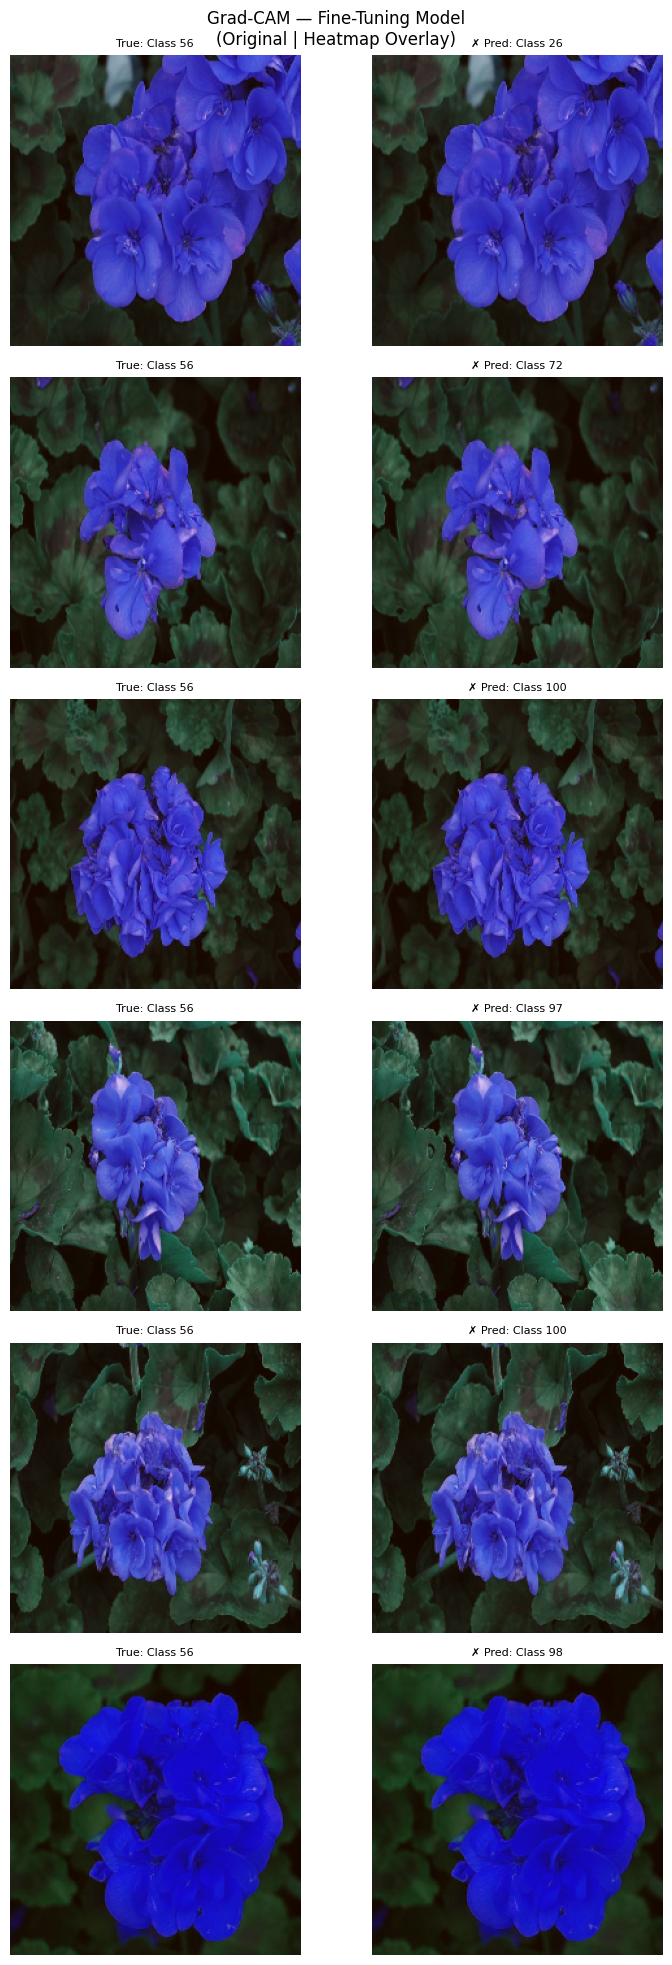

Grad-CAM saved!


In [59]:
# ============================================================
# 5. BONUS — Grad-CAM Heatmap Visualizations
# ============================================================
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads       = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap      = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap      = tf.squeeze(heatmap)
    heatmap      = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()

def overlay_heatmap(img, heatmap, alpha=0.4):
    heatmap_resized = tf.image.resize(heatmap[..., np.newaxis],
                                       [img.shape[0], img.shape[1]]).numpy().squeeze()
    cmap            = plt.get_cmap('jet')
    heatmap_colored = cmap(heatmap_resized)[..., :3]
    superimposed    = np.clip((1 - alpha) * img + alpha * heatmap_colored, 0, 1)
    return superimposed

# Find last conv layer in ResNet50 base
last_conv = None
for layer in reversed(fe_model.layers):
    if hasattr(layer, 'layers'):  # nested model (ResNet50)
        for sublayer in reversed(layer.layers):
            if isinstance(sublayer, tf.keras.layers.Conv2D):
                last_conv = sublayer.name
                break
    if last_conv:
        break
print(f"Last conv layer: {last_conv}")

# Collect 6 sample images from test set
samples = []
for images, labels in test_ds_norm.take(3):
    probs  = fe_model.predict(images, verbose=0)
    preds  = np.argmax(probs, axis=1)
    for img, true, pred in zip(images.numpy(), labels.numpy(), preds):
        samples.append((img, int(true), int(pred)))
        if len(samples) >= 6:
            break
    if len(samples) >= 6:
        break

# Plot Grad-CAM grid
fig, axes = plt.subplots(6, 2, figsize=(8, 20))
fig.suptitle('Grad-CAM — Fine-Tuning Model\n(Original | Heatmap Overlay)', fontsize=12)

for i, (img, true_label, pred_label) in enumerate(samples):
    # Normalize image back to [0,1] for display
    img_display = (img - img.min()) / (img.max() - img.min() + 1e-8)
    img_tensor  = tf.expand_dims(img, axis=0)

    try:
        heatmap = make_gradcam_heatmap(img_tensor, fe_model, last_conv, pred_index=pred_label)
        overlay = overlay_heatmap(img_display, heatmap)
    except:
        overlay = img_display

    status = '✓' if true_label == pred_label else '✗'
    axes[i, 0].imshow(img_display)
    axes[i, 0].set_title(f'True: Class {true_label}', fontsize=8)
    axes[i, 0].axis('off')

    axes[i, 1].imshow(overlay)
    axes[i, 1].set_title(f'{status} Pred: Class {pred_label}', fontsize=8)
    axes[i, 1].axis('off')

plt.tight_layout()
plt.savefig('/content/figures/gradcam_results.png', dpi=150, bbox_inches='tight')
plt.show()
print("Grad-CAM saved!")